# Useful variable gathering.
## Notes
First iteration is going to be a series of linked Lats and Longs. Don't worry too much about elevation, or make
some small if condition that might discourage going paths with too much elevation.

Describe lat and longs for each point in the path.

## Import data
Import the data using CSV files.

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
import pandas as pd
from scipy.spatial import KDTree
import networkx as nx
import numpy as np
import osmnx as ox

In [2]:
df = pd.read_csv('carrauntoohil_data_set.csv')
points = list(zip(round(df['latitude'], 7), round(df['longitude'], 7), round(df['elevation'], 2)))
print(points[7])

(51.990047, -9.7296555, 824.82)


# Return the highest and lowest values from the set.
Using Pandas dataframes and the min() and max() methods to determine the lowest and highest values of the set.

In [3]:
lowest = min(points, key=lambda x: x[2])
highest = max(points, key=lambda x: x[2])
round(highest[0], 7), round(highest[1], 7), round(lowest[0], 7), round(lowest[1], 7)

(51.9989501, -9.7433861, 52.0023674, -9.7296555)

## Create a Graph from data points using the NetworkX Library.
Using a SciPy KDTree implementation, the nearest neighbours can be assessed.

In [4]:
G = nx.Graph()
tree = KDTree([(lat, lon) for lat, lon, _ in points])

## Loop through the points array.
This allows the data to be iterated and stored in a series of points.
This allows assigning of indices based on neighbour values.
Adds edge weighting based on the distance of elevation between points.
There's a lot going on here, may take a few seconds to run.

In [5]:
for i, (lat, lon, elev) in enumerate(points):
  G.add_node(i, pos=(lat, lon), elevation=elev)
  distances, indices = tree.query((lat, lon), k=5)
  for j, dist in zip(indices, distances):
    if j != i:
      elev_diff = abs(elev - points[j][2])
      G.add_edge(i,j, weight=elev_diff + dist)

### Define the source and destination points and use Dijkstra's(Shortest Path First) to find shortest path.
Using the Networkx module, changing the algorithm for pathfinding is as simple as changing the name of the nx method.

#### Using Shortest Path First Algorithm
`path = nx.shortest_path(G, source=start, target=end, weight="weight")` - Shortest path using shortest path algorithm.

#### Using A* Algorithm
`path = nx.astar_path(G, source=start, target=end, weight="weight")` - Shortest path using A*.

In [6]:
start = points.index(lowest)
end = points.index(highest)
path = nx.astar_path(G, source=start, target=end, weight="weight") # A Star path algorithm with cost function depending on elevation.
path_coords = [(df.iloc[i]['latitude'], df.iloc[i]['longitude']) for i in path]
print(path_coords)

[(np.float64(52.00236741), np.float64(-9.72965549)), (np.float64(52.00236741), np.float64(-9.72980156)), (np.float64(52.00236741), np.float64(-9.72994763)), (np.float64(52.00236741), np.float64(-9.7300937)), (np.float64(52.00236741), np.float64(-9.73023977)), (np.float64(52.00236741), np.float64(-9.73038584)), (np.float64(52.00236741), np.float64(-9.73053191)), (np.float64(52.00236741), np.float64(-9.73067798)), (np.float64(52.00236741), np.float64(-9.73082405)), (np.float64(52.00236741), np.float64(-9.73097012)), (np.float64(52.00236741), np.float64(-9.73111619)), (np.float64(52.00236741), np.float64(-9.73126226)), (np.float64(52.00236741), np.float64(-9.73140833)), (np.float64(52.00236741), np.float64(-9.7315544)), (np.float64(52.00236741), np.float64(-9.73170047)), (np.float64(52.00236741), np.float64(-9.73184654)), (np.float64(52.00236741), np.float64(-9.73199261)), (np.float64(52.00236741), np.float64(-9.73213868)), (np.float64(52.00236741), np.float64(-9.73228475)), (np.float64(5

# Using Folium to display the completed map.

In [7]:
import folium
# Get middle values.
mid_lat = (lowest[0] + highest[0]) / 2
mid_lon = (lowest[1] + highest[1]) / 2
m = folium.Map(location=[mid_lat, mid_lon], zoom_start=13)

# Map markers for lowest and highest points.
folium.Marker(location=[lowest[0], lowest[1]], popup="Lowest Point", icon=folium.Icon(color="green")).add_to(m)
folium.Marker(location=[highest[0], highest[1]], popup="Highest Point", icon=folium.Icon(color="red")).add_to(m)

# Add the path as a polyline to the html file.
folium.PolyLine(locations=path_coords, color="blue", weight=3, opacity=0.7).add_to(m)

# Save map to HTML file
m.save("path_map.html")

## Get the Path Data from Paths
The paths in the surrounding area can be assessed using the OpenStreetMap (OSMNX) library, and works from inserting a point in the same way the script does.

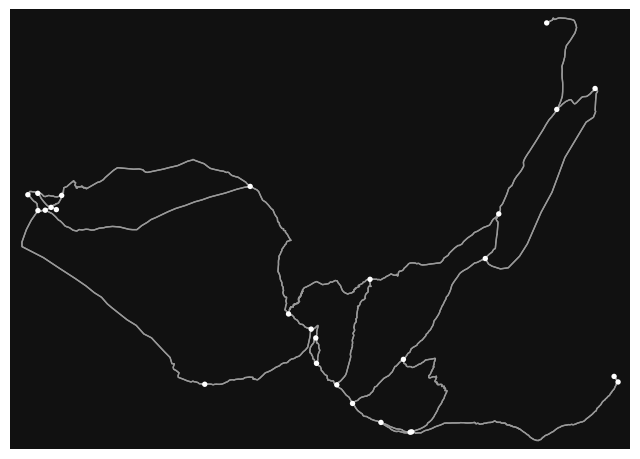

In [8]:
def produce_hiking_paths():
    import osmnx as ox

    tags = {"highway": "path"}
    # 3000 is the minimum distance where all paths are accounted for.
    G = ox.graph_from_point((highest[0], highest[1]), dist=3000, network_type="walk", custom_filter='["highway"~"path|footway|track"]')
    # G = ox.graph_from_point((28.0026, 86.8528), dist=3000, network_type="walk", custom_filter='["highway"~"path|footway|track"]') // Everest.
    nodes, edges = ox.graph_to_gdfs(G) # This is where the Graph is converted to MultiDirectional

    edges.to_file("hiking_paths.geojson")
    ox.plot_graph(G)
produce_hiking_paths()

## Extract Latitudes and Longitudes from hiking paths file.
The paths can be extracted using the GeoPandas library, which makes this process easy. The JSON library was not used for this purpose, as the keys would all have to be accessed individually in each instance, therefore it became necessary to find other solutions.

In [9]:
geo_data_frame = gpd.read_file('hiking_paths.geojson')
# Note: They WILL combine now.
graph_geo = nx.Graph()

for idx, row in geo_data_frame.iterrows():
  geom = row.geometry
  if geom.geom_type == "LineString":
    coords = list(geom.coords)
    for i, pt in enumerate(coords):
      node_id = f"{idx}_{i}"
      graph_geo.add_node(node_id, pos=pt)
    for i in range(len(coords) - 1):
      node_a = f"{idx}_{i}"
      node_b = f"{idx}_{i + 1}"
      graph_geo.add_edge(node_a, node_b)
print(graph_geo.number_of_nodes())
print(isinstance(graph_geo, nx.MultiDiGraph), isinstance(G, nx.MultiDiGraph))
print(graph_geo.number_of_nodes(), graph_geo.number_of_edges()) # 40401 is the correct number of nodes from the 'G' graph.
print(G.number_of_nodes(), G.number_of_edges())

Skipping field highway: unsupported OGR type: 5


3052
False False
3052 2980
40401 81204


## Extracting the LineString data from `hiking_paths.geojson`

In [10]:
def add_path_data():
  geo_data_frame = gpd.read_file('hiking_paths.geojson')
  coords = []
  for geom in geo_data_frame['geometry']:
    if geom.geom_type == 'LineString':
      for lon, lat in geom.coords:
        coords.append((lat, lon))
  sorted_coordinates = sorted(set(coords), key=lambda x: (x[0], x[1])) # Sorts by first key, then second.
  return sorted_coordinates # Calling this later

## Get Elevation Method
This method needs to be called here, as the one in generate_data_set.py is tied into that file, and cannot be used elsewhere.

In [11]:
# Get elevation Data for that set
import os
import csv
import requests
api_key = os.environ.get("GOOGLE_API_KEY")
def get_elevation(lat, lon, api_key):
  url = f"https://maps.googleapis.com/maps/api/elevation/json?locations={lat},{lon}&key={api_key}"
  response = requests.get(url)
  results = response.json().get('results')
  elevation = results[0]['elevation']
  return round(elevation, 2)

## Append Path Data to CSV File
The path data here can be transferred to a CSV file, so that it can be merged with already existing data sets.
File can be found [here](path_terrain_set.csv)

In [12]:
# Append rows to CSV
coords_list = add_path_data() # Only run this when necessary. As such, it is not called here directly.
def append_rows(coords_list):
  if os.path.exists('test.csv'): # Added check that only runs when file already exists.
    print("File already exists.")
    return
  rows = []
  for lat, lon in coords_list:
    elev = get_elevation(lat, lon, api_key)
    rows.append([lat, lon, elev])
  with open('test.csv', 'x', newline='') as csvfile: # X creates new file if not already exists.
    csvwriter = csv.writer(csvfile)
    for row in rows:
      csvwriter.writerow(row)
append_rows(coords_list)

Skipping field highway: unsupported OGR type: 5


File already exists.
